# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

## Initialization

In [75]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


## Load data

In [76]:
# Load the data files into different DataFrames
plans_df = pd.read_csv('/datasets/megaline_plans.csv')
users_df = pd.read_csv('/datasets/megaline_users.csv')
calls_df = pd.read_csv('/datasets/megaline_calls.csv')
messages_df = pd.read_csv('/datasets/megaline_messages.csv')
internet_df = pd.read_csv('/datasets/megaline_internet.csv')


## Prepare the data

## Plans

In [77]:
# Print the general/summary information about the plans' DataFrame
plans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [78]:
# Print a sample of data for plans
plans_df.sample(2)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
1,1000,30720,3000,70,7,0.01,0.01,ultimate
0,50,15360,500,20,10,0.03,0.03,surf


## Fix data

From looking at the data above I can tell that usd_monthly_pay represent US dollars. So changing it to a float respreset the data correctly.

In [79]:
plans_df['usd_monthly_pay'] = plans_df['usd_monthly_pay'].astype(float)

display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20.0,10,0.03,0.03,surf
1,1000,30720,3000,70.0,7,0.01,0.01,ultimate


## Enrich data

**Total Monthly Cost:** Calculate the total monthly cost for each plan, taking in account the base monhtly charge and any additional costs for exceeding the plan limits.

I convert the plan's data allowance from mb to gb because overage cost(usd_per_gb) is us dollars per gigabytes. 

In [80]:
plans_df['total_monthly_cost'] = plans_df['usd_monthly_pay'] + plans_df['usd_per_gb'] * (plans_df['mb_per_month_included'] / 1024) + plans_df['usd_per_message'] * plans_df['messages_included'] + plans_df['usd_per_minute'] * plans_df['minutes_included']
display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,total_monthly_cost
0,50,15360,500,20.0,10,0.03,0.03,surf,186.5
1,1000,30720,3000,70.0,7,0.01,0.01,ultimate,320.0


**Effective Cost Per Minute/Message/GB:** Calculate the effective cost per minute, message, and gigabyte by dividing the total monthly cost by the corresponding included amounts.<br>
Doing this helps me understand how much users are being charged for services beyond the included amount.

In [81]:
plans_df['effective_cost_per_minute'] = plans_df['total_monthly_cost'] / plans_df['minutes_included']
plans_df['effective_cost_per_message'] = plans_df['total_monthly_cost'] / plans_df['messages_included']
plans_df['effective_cost_per_gb'] = plans_df['total_monthly_cost'] / (plans_df['mb_per_month_included'] / 1024) # convert from mb to gb
display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,total_monthly_cost,effective_cost_per_minute,effective_cost_per_message,effective_cost_per_gb
0,50,15360,500,20.0,10,0.03,0.03,surf,186.5,0.373000,3.73,12.433333
1,1000,30720,3000,70.0,7,0.01,0.01,ultimate,320.0,0.106667,0.32,10.666667


## Users

In [82]:
# Print the general/summary information about the users' DataFrame
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [83]:
# Print a sample of data for users
users_df.sample(10)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
65,1065,Sherlyn,Noel,26,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-08-03,surf,NaN
451,1451,Lenard,Harding,53,"Charlotte-Concord-Gastonia, NC-SC MSA",2018-02-15,ultimate,2018-12-10
47,1047,Yuk,French,22,"Indianapolis-Carmel-Anderson, IN MSA",2018-06-16,ultimate,NaN
234,1234,Matt,Taylor,19,"Seattle-Tacoma-Bellevue, WA MSA",2018-09-12,ultimate,NaN
429,1429,Arianna,Rowe,36,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-12-22,surf,NaN
310,1310,Vincent,Fry,73,"Portland-Vancouver-Hillsboro, OR-WA MSA",2018-11-29,surf,NaN
229,1229,Augustus,Barker,69,"Austin-Round Rock-Georgetown, TX MSA",2018-12-09,ultimate,NaN
48,1048,Linwood,Terrell,42,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-08-24,surf,NaN
71,1071,Isa,Roy,29,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-05-23,surf,NaN
300,1300,Rene,Frost,23,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-10-21,surf,2018-12-19


[Describe what you see and notice in the general information and the printed data sample for the above price of data. Are there any issues (inappropriate data types, missing data etc) that may need further investigation and changes? How that can be fixed?]

### Fix Data

**Issues:** The "reg_date" and "churn_date" columns should be datetime data type. They are currently in string format.
The "churn_date" column contains NaN values, indicating that not all users have churned. This is expected behavior, so no further changes are needed.<br>

**Fixes:** Convert the "reg_date" and "churn_date" columns to datetime data type.

In [84]:
users_df['reg_date'] =  pd.to_datetime(users_df['reg_date'])
users_df['churn_date'] = pd.to_datetime(users_df['churn_date'])

In [85]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


**Calculate User Tenure:** Calculate how long each user has been with the sevice. This can help analyze user rentention and behavior over time.

In [86]:
users_df['user_tenure'] = (users_df['churn_date'] - users_df['reg_date']).dt.days
users_with_tenure = users_df[users_df['user_tenure'].notna()]
display(users_with_tenure)

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,user_tenure
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,21.0
12,1012,Jonelle,Mcbride,59,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-06-28,surf,2018-11-16,141.0
22,1022,Bo,Snow,73,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-04-20,surf,2018-09-07,140.0
40,1040,Paris,Santos,72,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-12-23,surf,2018-12-30,7.0
50,1050,Jone,Owen,23,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-03-20,ultimate,2018-10-07,201.0
54,1054,Denis,Frost,50,"Phoenix-Mesa-Chandler, AZ MSA",2018-04-21,surf,2018-12-31,254.0
67,1067,Robt,Allen,37,"Grand Rapids-Kentwood, MI MSA",2018-09-24,surf,2018-11-24,61.0
83,1083,Lyndia,Acevedo,65,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-26,surf,2018-12-18,53.0
84,1084,Wiley,Mckinney,21,"Miami-Fort Lauderdale-West Palm Beach, FL MSA",2018-06-04,surf,2018-11-11,160.0
94,1094,Walter,Petersen,54,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-30,surf,2018-12-12,43.0


**Categorize Age Groups:** Placing user in age groups to analyze how different age groups in term of plan usage.

In [87]:
bins = [0, 30, 50, 120]
labels = ['Young', 'Middle-aged', 'Senior']
users_df['age_group'] = pd.cut(users_df['age'], bins=bins, labels=labels)

display(users_df.head(15))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,user_tenure,age_group
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,NaN,Middle-aged
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,NaN,Young
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,NaN,Middle-aged
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,NaN,Senior
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,NaN,Middle-aged
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaT,NaN,Middle-aged
6,1006,Jesusa,Bradford,73,"San Francisco-Oakland-Berkeley, CA MSA",2018-11-27,ultimate,2018-12-18,21.0,Senior
7,1007,Eusebio,Welch,42,"Grand Rapids-Kentwood, MI MSA",2018-07-11,surf,NaT,NaN,Middle-aged
8,1008,Emely,Hoffman,53,"Orlando-Kissimmee-Sanford, FL MSA",2018-08-03,ultimate,NaT,NaN,Senior
9,1009,Gerry,Little,19,"San Jose-Sunnyvale-Santa Clara, CA MSA",2018-04-22,surf,NaT,NaN,Young


**Extracting State:** Extracting the state from the city column to analyze user behavior based on their location.

In [88]:
users_df['state'] = users_df['city'].str.split(', ').str[-1].str.strip()

# Creating a column "is_in_msa" because 'MSA' is mention in two different spots now.
users_df['is_in_msa'] = users_df['city'].str.contains('MSA').astype(int)

# Removing 'MSA' from 'city' and 'state' now that I have a column for it.
users_df['city'] = users_df['city'].str.replace(r',.*$', '', regex=True)
users_df['state'] = users_df['state'].str.replace(r' .*$', '', regex=True)

display(users_df.head(15))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,user_tenure,age_group,state,is_in_msa
0,1000,Anamaria,Bauer,45,Atlanta-Sandy Springs-Roswell,2018-12-24,ultimate,NaT,NaN,Middle-aged,GA,1
1,1001,Mickey,Wilkerson,28,Seattle-Tacoma-Bellevue,2018-08-13,surf,NaT,NaN,Young,WA,1
2,1002,Carlee,Hoffman,36,Las Vegas-Henderson-Paradise,2018-10-21,surf,NaT,NaN,Middle-aged,NV,1
3,1003,Reynaldo,Jenkins,52,Tulsa,2018-01-28,surf,NaT,NaN,Senior,OK,1
4,1004,Leonila,Thompson,40,Seattle-Tacoma-Bellevue,2018-05-23,surf,NaT,NaN,Middle-aged,WA,1
5,1005,Livia,Shields,31,Dallas-Fort Worth-Arlington,2018-11-29,surf,NaT,NaN,Middle-aged,TX,1
6,1006,Jesusa,Bradford,73,San Francisco-Oakland-Berkeley,2018-11-27,ultimate,2018-12-18,21.0,Senior,CA,1
7,1007,Eusebio,Welch,42,Grand Rapids-Kentwood,2018-07-11,surf,NaT,NaN,Middle-aged,MI,1
8,1008,Emely,Hoffman,53,Orlando-Kissimmee-Sanford,2018-08-03,ultimate,NaT,NaN,Senior,FL,1
9,1009,Gerry,Little,19,San Jose-Sunnyvale-Santa Clara,2018-04-22,surf,NaT,NaN,Young,CA,1


**User Churn Indicator:** Creating a column to indicate whether a user has churned(1 for churned, 0 for active).

In [89]:
users_df['churned'] = users_df['churn_date'].notna().astype(int)
sample1 = users_df.query('churned == 0')

display(sample1.sample(5))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,user_tenure,age_group,state,is_in_msa,churned
438,1438,Harvey,Brooks,36,Orlando-Kissimmee-Sanford,2018-06-15,surf,NaT,NaN,Middle-aged,FL,1,0
452,1452,Miguel,Sparks,32,Tucson,2018-12-29,surf,NaT,NaN,Middle-aged,AZ,1,0
419,1419,Bryon,Gordon,45,Phoenix-Mesa-Chandler,2018-03-29,surf,NaT,NaN,Middle-aged,AZ,1,0
339,1339,Mariette,Mclean,27,Charlotte-Concord-Gastonia,2018-03-03,surf,NaT,NaN,Young,NC-SC,1,0
46,1046,Beata,Hooper,67,Boston-Cambridge-Newton,2018-02-19,surf,NaT,NaN,Senior,MA-NH,1,0


In [90]:
sample2 = users_df.query('churned == 1')

display(sample2.sample(5))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,user_tenure,age_group,state,is_in_msa,churned
246,1246,Stevie,Moran,69,Tampa-St. Petersburg-Clearwater,2018-01-09,ultimate,2018-07-31,203.0,Senior,FL,1,1
94,1094,Walter,Petersen,54,Los Angeles-Long Beach-Anaheim,2018-10-30,surf,2018-12-12,43.0,Senior,CA,1,1
491,1491,Terina,Jensen,22,Grand Rapids-Kentwood,2018-04-27,surf,2018-09-18,144.0,Young,MI,1,1
358,1358,Vaughn,Maldonado,20,New York-Newark-Jersey City,2018-04-26,surf,2018-10-22,179.0,Young,NY-NJ-PA,1,1
281,1281,Zack,Hardy,39,Charlotte-Concord-Gastonia,2018-07-23,surf,2018-11-14,114.0,Middle-aged,NC-SC,1,1


**Plan Subscribers Count:** Calculate the number of subscribers for each plan to understand the distribution of users between plans.

In [91]:
plan_subscribers_count = users_df['plan'].value_counts().reset_index()
plan_subscribers_count.columns = ['plan', 'subscribers_count']

display(plan_subscribers_count)

,plan,subscribers_count
0,surf,339
1,ultimate,161


**Calculate Average Tenure by Plan:** Calculate the average tenure for users of each calling plan to see if there's a difference in user loyalty between plans.

In [92]:
# Calculate average tenure by plan
average_tenure_by_plan = users_df.groupby('plan')['user_tenure'].mean().reset_index()
average_tenure_by_plan.rename(columns={'user_tenure': 'avg_user_tenure'}, inplace=True)

display(average_tenure_by_plan)

,plan,avg_user_tenure
0,surf,127.869565
1,ultimate,170.454545


## Calls

In [93]:
# Print the general/summary information about the calls' DataFrame
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [94]:
# Print a sample of data for calls
calls_df.sample(5)

,id,user_id,call_date,duration
98998,1354_558,1354,2018-09-21,1.06
83423,1302_197,1302,2018-10-03,15.20
81936,1295_318,1295,2018-11-29,7.88
41395,1153_7,1153,2018-12-10,8.35
55412,1198_156,1198,2018-11-15,11.03


### Fix data

**Issues and Fixes:** <br>
The 'call_date' column is currently a object data type, which should be a datetime data type. <br>
The 'id' column seems to contain two pieces of information. One has to be the 'id' number and the other I believe might be a number to indentify seperate calls made by the user. After researching telecommunications data analysis, addding this ensures that each call record is uniquely indentifiable. If thats the case there is no need to change the 'id' column.
Lastly, rounding up call duration to the nearest mintue is a common practice in telecommunications billing for reason like billing precision, simplicity, predictability, and  technical considerations.

In [95]:
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'], format='%Y-%m-%d')
calls_df['duration'] = np.ceil(calls_df['duration']).astype(int) # rounding up call duration

In [96]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         137735 non-null  object        
 1   user_id    137735 non-null  int64         
 2   call_date  137735 non-null  datetime64[ns]
 3   duration   137735 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 4.2+ MB


In [97]:
calls_df.sample(5)

,id,user_id,call_date,duration
2893,1010_507,1010,2018-10-05,15
79343,1284_463,1284,2018-12-23,11
25870,1099_192,1099,2018-10-06,20
25790,1099_110,1099,2018-09-24,6
52307,1187_500,1187,2018-12-11,11


### Enrich data

In [98]:
# Extracting month and day of the week from the call date for time related features and patteren between days
calls_df['call_month'] = pd.to_datetime(calls_df['call_date']).dt.month
calls_df['call_day_of_week'] = pd.to_datetime(calls_df['call_date']).dt.dayofweek

# Creating a column to indicate weekends(1) and weekdays(0)
calls_df['is_weekend'] = (calls_df['call_day_of_week'] >= 5).astype(int)

display(calls_df.sample(15))

,id,user_id,call_date,duration,call_month,call_day_of_week,is_weekend
7884,1037_62,1037,2018-12-26,2,12,2,0
74,1001_109,1001,2018-10-27,0,10,5,1
133555,1483_398,1483,2018-09-02,11,9,6,1
100438,1359_314,1359,2018-04-09,6,4,0,0
57497,1206_279,1206,2018-12-21,5,12,4,0
57441,1206_197,1206,2018-11-20,12,11,1,0
61419,1222_66,1222,2018-08-21,12,8,1,0
86812,1320_481,1320,2018-11-30,10,11,4,0
114702,1401_558,1401,2018-11-04,9,11,6,1
107969,1382_952,1382,2018-07-11,12,7,2,0


**User-related Information**

In [99]:
# Merge the calls DataFrame with the users DataFrame to add user-specific details
calls_df = calls_df.merge(users_df[['user_id', 'first_name', 'last_name', 'age', 'city', 'state', 'plan']], on='user_id', how='left')

# Calculate the number of calls made by each user per month
calls_per_month = calls_df.groupby(['user_id', 'call_month']).size().reset_index(name='calls_per_month')
calls_df = calls_df.merge(calls_per_month, on=['user_id', 'call_month'], how='left')

# Calculate the total call duration for each user per month
total_duration_per_month = calls_df.groupby(['user_id', 'call_month'])['duration'].sum().reset_index(name='total_duration_per_month')
calls_df = calls_df.merge(total_duration_per_month, on=['user_id', 'call_month'], how='left')

In [100]:
display(calls_df.sample(5))

,id,user_id,call_date,duration,call_month,call_day_of_week,is_weekend,first_name,last_name,age,city,state,plan,calls_per_month,total_duration_per_month
130904,1470_353,1470,2018-07-05,20,7,3,0,Gerald,Reese,45,Washington-Arlington-Alexandria,DC-VA-MD-WV,surf,75,524
33089,1123_447,1123,2018-09-20,9,9,3,0,Dierdre,Nash,66,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,surf,70,460
90858,1328_488,1328,2018-09-16,4,9,6,1,Tamesha,Huber,20,Minneapolis-St. Paul-Bloomington,MN-WI,surf,92,658
108144,1382_1277,1382,2018-09-23,18,9,6,1,Luci,Kidd,49,San Diego-Chula Vista-Carlsbad,CA,ultimate,160,1232
27992,1106_332,1106,2018-09-02,6,9,6,1,Eddy,Garrison,47,New York-Newark-Jersey City,NY-NJ-PA,surf,81,504


**Plan-related Data**

In [101]:
# Merge the calls DataFrame with the plans DataFrame to add plan-specific details
calls_df = calls_df.merge(plans_df, left_on='plan', right_on='plan_name', how='left')

# Calculate call charges for each user based on the plan they are using
calls_df['call_charges'] = calls_df['duration'] * calls_df['usd_per_minute']

display(calls_df.sample(5))

,id,user_id,call_date,duration,call_month,call_day_of_week,is_weekend,first_name,last_name,age,...,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,total_monthly_cost,effective_cost_per_minute,effective_cost_per_message,effective_cost_per_gb,call_charges
81557,1293_762,1293,2018-12-11,3,12,1,0,Lanny,Nolan,23,...,20.0,10,0.03,0.03,surf,186.5,0.373000,3.73,12.433333,0.09
3271,1011_124,1011,2018-07-21,0,7,5,1,Halina,Henry,73,...,70.0,7,0.01,0.01,ultimate,320.0,0.106667,0.32,10.666667,0.00
56778,1203_169,1203,2018-10-31,2,10,2,0,Manie,Grimes,50,...,20.0,10,0.03,0.03,surf,186.5,0.373000,3.73,12.433333,0.06
48605,1174_582,1174,2018-12-13,17,12,3,0,Larisa,Ellis,67,...,20.0,10,0.03,0.03,surf,186.5,0.373000,3.73,12.433333,0.51
92066,1330_270,1330,2018-12-16,0,12,6,1,Tobi,Kinney,48,...,70.0,7,0.01,0.01,ultimate,320.0,0.106667,0.32,10.666667,0.00


**Location-related Feature**

In [102]:
# Determin the regoin or state from user's location
calls_df['region'] = calls_df['city'].str.split(', ').str[-1]

# Explore call patterns based on the region
region_calls_stats = calls_df.groupby(['region', 'call_month'])[['duration', 'calls_per_month']].mean().reset_index()

display(region_calls_stats.sample(10))

,region,call_month,duration,calls_per_month
20,Atlanta-Sandy Springs-Roswell,10,7.162214,93.824427
307,Miami-Fort Lauderdale-West Palm Beach,12,7.212766,81.494272
411,Portland-Vancouver-Hillsboro,10,6.781182,84.483589
87,Cape Coral-Fort Myers,12,7.428571,56.000000
51,Baton Rouge,8,6.839181,124.754386
223,Houston-The Woodlands-Sugar Land,11,7.518644,72.206780
115,Cincinnati,4,5.761905,21.000000
470,San Diego-Chula Vista-Carlsbad,8,6.814947,136.259786
40,Baltimore-Columbia-Towson,5,7.078125,64.000000
59,Birmingham-Hoover,9,7.340426,47.000000


**Statistical Feature**

In [103]:
# Calculate summary statistics for call duration per user
user_stats = calls_df.groupby('user_id')['duration'].agg(['mean', 'var', 'std']).reset_index()
calls_df = calls_df.merge(user_stats, on='user_id', how='left')

In [104]:
display(calls_df.sample(5))

,id,user_id,call_date,duration,call_month,call_day_of_week,is_weekend,first_name,last_name,age,...,plan_name,total_monthly_cost,effective_cost_per_minute,effective_cost_per_message,effective_cost_per_gb,call_charges,region,mean,var,std
122769,1434_59,1434,2018-06-18,12,6,0,0,Kai,Barr,18,...,surf,186.5,0.373000,3.73,12.433333,0.36,New York-Newark-Jersey City,6.794793,32.798316,5.726981
26094,1099_418,1099,2018-07-13,10,7,4,0,Shavon,Banks,48,...,surf,186.5,0.373000,3.73,12.433333,0.30,New York-Newark-Jersey City,7.074901,36.100961,6.008408
45077,1163_136,1163,2018-09-12,10,9,2,0,Lanie,Washington,27,...,ultimate,320.0,0.106667,0.32,10.666667,0.10,Los Angeles-Long Beach-Anaheim,7.347222,34.628405,5.884590
114335,1400_687,1400,2018-11-27,0,11,1,0,Kenton,Hickman,72,...,surf,186.5,0.373000,3.73,12.433333,0.00,Riverside-San Bernardino-Ontario,7.119318,36.955871,6.079134
6891,1032_41,1032,2018-12-23,4,12,6,1,Delila,Dalton,59,...,ultimate,320.0,0.106667,0.32,10.666667,0.04,Birmingham-Hoover,8.000000,38.857143,6.233550


**Seasonal or Event Data:** 

In [105]:
# List of holidays or events and their dates
holidays = {
    'New Year': '2018-01-01',
    'Independence Day': '2018-07-04',
    'Thanksgiving': '2018-11-22',
    'Christmas': '2018-12-25',
    # Add more holidays or events as needed
}

# Create a DataFrame with holidays/event names and date
holidays_df = pd.DataFrame(list(holidays.items()), columns=['holiday_name', 'holiday_date'])

# Convert 'holiday_date' to datetime format
holidays_df['holiday_date'] = pd.to_datetime(holidays_df['holiday_date'])

# Merge the holidays DataFrame with calls DataFrame based on the call_date
calls_df['call_date'] = pd.to_datetime(calls_df['call_date'])
calls_df = calls_df.merge(holidays_df, left_on='call_date', right_on='holiday_date', how='left')

# Create a new column to indicate whether a call happen ona holiday/event (1) for yes (0) for no
calls_df['is_holiday'] = (~calls_df['holiday_name'].isna()).astype(int)


calls_df = calls_df.drop(columns='holiday_date')


sample1 = calls_df.query('is_holiday == 1')


display(sample1.sample(5))

,id,user_id,call_date,duration,call_month,call_day_of_week,is_weekend,first_name,last_name,age,...,effective_cost_per_minute,effective_cost_per_message,effective_cost_per_gb,call_charges,region,mean,var,std,holiday_name,is_holiday
108740,1384_57,1384,2018-07-04,2,7,2,0,Dominique,Good,36,...,0.106667,0.32,10.666667,0.02,Philadelphia-Camden-Wilmington,7.046414,36.044447,6.003703,Independence Day,1
22856,1083_105,1083,2018-12-25,10,12,1,0,Lyndia,Acevedo,65,...,0.373000,3.73,12.433333,0.30,Los Angeles-Long Beach-Anaheim,8.321429,38.256113,6.185153,Christmas,1
24167,1090_349,1090,2018-11-22,10,11,3,0,Brock,Skinner,30,...,0.373000,3.73,12.433333,0.30,Indianapolis-Carmel-Anderson,6.821340,30.604817,5.532162,Thanksgiving,1
93563,1334_931,1334,2018-12-25,17,12,1,0,Donovan,Horton,34,...,0.373000,3.73,12.433333,0.51,Seattle-Tacoma-Bellevue,7.122807,35.595090,5.966162,Christmas,1
11610,1050_385,1050,2018-11-22,1,11,3,0,Jone,Owen,23,...,0.106667,0.32,10.666667,0.01,Miami-Fort Lauderdale-West Palm Beach,6.797323,32.207886,5.675199,Thanksgiving,1


## Messages

In [32]:
# Print the general/summary information about the messages' DataFrame
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [33]:
# Print a sample of data for messages
messages_df.sample(5)

,id,user_id,message_date
74585,1481_38,1481,2018-12-28
18592,1120_442,1120,2018-07-28
39182,1255_223,1255,2018-08-30
7781,1060_117,1060,2018-09-19
65744,1424_57,1424,2018-12-25


**Issues and Fixes:** 'message_date is and object and it needs too be converted to a datetime data type.

### Fix data

In [34]:
messages_df['message_date'] = pd.to_datetime(messages_df['message_date'], format='%Y-%m-%d')

messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


## Internet

In [35]:
# Print the general/summary information about the internet DataFrame
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [36]:
# Print a sample of data for the internet traffic
internet_df.sample(5)

,id,user_id,session_date,mb_used
74856,1353_19,1353,2018-08-18,297.04
8012,1043_58,1043,2018-10-15,745.90
46696,1206_698,1206,2018-08-16,285.80
80768,1377_193,1377,2018-08-18,0.00
18783,1084_45,1084,2018-11-09,68.44


### Fix data

In [37]:
# Converting 'session_date' to a datetime data type and rounding 'mb_used' up.
internet_df['session_date'] = pd.to_datetime(internet_df['session_date'], format='%Y-%m-%d')
internet_df['mb_used'] = np.ceil(internet_df['mb_used']).astype(int)

In [38]:
internet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            104825 non-null  object        
 1   user_id       104825 non-null  int64         
 2   session_date  104825 non-null  datetime64[ns]
 3   mb_used       104825 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.2+ MB


In [39]:
internet_df.sample(5)

,id,user_id,session_date,mb_used
21992,1100_196,1100,2018-11-02,641
42970,1191_149,1191,2018-06-13,882
39562,1178_158,1178,2018-10-28,227
28893,1132_338,1132,2018-06-25,0
8058,1043_130,1043,2018-11-22,0


### Enrich data

**Data Usage Rounding**

In [40]:
internet_df['gb_used'] = internet_df['mb_used'] / 1024
internet_df['kb_used'] = (internet_df['mb_used'] * 1024).round().astype(int)

internet_df.sample(5)

,id,user_id,session_date,mb_used,gb_used,kb_used
78504,1366_193,1366,2018-08-30,0,0.000000,0
58732,1264_77,1264,2018-10-18,270,0.263672,276480
78181,1364_367,1364,2018-09-14,20,0.019531,20480
36465,1164_148,1164,2018-10-17,884,0.863281,905216
49495,1221_397,1221,2018-12-21,172,0.167969,176128


**Data Usage Categorization**

In [41]:
internet_df['usage_category'] = pd.cut(internet_df['mb_used'], bins=[0, 100, 500, 1000], labels=['Low Usage', 'Medium Usage', 'High Usage'])
internet_df.sample(5)

,id,user_id,session_date,mb_used,gb_used,kb_used,usage_category
38876,1174_139,1174,2018-10-14,773,0.754883,791552,High Usage
32309,1146_187,1146,2018-12-08,200,0.195312,204800,Medium Usage
54743,1247_158,1247,2018-08-16,24,0.023438,24576,Low Usage
51045,1230_13,1230,2018-12-20,412,0.402344,421888,Medium Usage
91058,1419_28,1419,2018-12-10,432,0.421875,442368,Medium Usage


## Study plan conditions

In [42]:
# Print out the plan conditions and make sure they are clear for you
display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,total_monthly_cost,effective_cost_per_minute,effective_cost_per_message,effective_cost_per_gb
0,50,15360,500,20.0,10,0.03,0.03,surf,186.5,0.373000,3.73,12.433333
1,1000,30720,3000,70.0,7,0.01,0.01,ultimate,320.0,0.106667,0.32,10.666667


## Aggregate data per user


In [43]:
# Calculate the number of calls made by each user per month. Save the result.
# Calculate the amount of minutes spent by each user per month. Save the result.
calls_df['month'] = calls_df['call_date'].dt.to_period('M')
user_call_stats = calls_df.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum']).rename(columns={'count': 'call_count', 'sum': 'call_minutes'})

In [44]:
# Calculate the number of messages sent by each user per month. Save the result.
messages_df['month'] = messages_df['message_date'].dt.to_period('M')
user_message_stats = messages_df.groupby(['user_id', 'month'])[['id']].count().rename(columns={'id': 'message_count'})

In [45]:
# Calculate the volume of internet traffic used by each user per month. Save the result.
internet_df['month'] = internet_df['session_date'].dt.to_period('M')
user_internet_stats = internet_df.groupby(['user_id', 'month'])[['mb_used']].sum().rename(columns={'mb_used': 'internet_usage'})

In [46]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
user_activity = pd.concat([user_call_stats, user_message_stats, user_internet_stats], axis=1)
display(user_activity.sample(10))

,,call_count,call_minutes,message_count,internet_usage
user_id,month,,,,
1385,2018-05,68.0,547.0,38.0,15341.0
1164,2018-09,62.0,450.0,29.0,14090.0
1156,2018-12,48.0,400.0,NaN,17507.0
1399,2018-09,40.0,303.0,23.0,21025.0
1215,2018-10,123.0,899.0,96.0,30970.0
1085,2018-11,79.0,525.0,NaN,25087.0
1385,2018-12,76.0,563.0,43.0,16622.0
1417,2018-09,81.0,573.0,7.0,14883.0
1282,2018-11,64.0,433.0,NaN,17321.0


In [47]:
# Add the plan information
user_plan = users_df[['user_id', 'plan']]
user_activity = user_activity.reset_index()
user_activity = user_activity.merge(user_plan, on='user_id', how='left')

display(user_activity.sample(5))

,user_id,month,call_count,call_minutes,message_count,internet_usage,plan
2075,1447,2018-11,69.0,482.0,68.0,40257.0,surf
1241,1261,2018-06,61.0,441.0,52.0,13101.0,surf
566,1120,2018-10,58.0,394.0,43.0,17890.0,surf
1045,1220,2018-04,21.0,121.0,18.0,5265.0,surf
1116,1236,2018-12,81.0,594.0,29.0,19731.0,ultimate


In [48]:
display(plans_df)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,total_monthly_cost,effective_cost_per_minute,effective_cost_per_message,effective_cost_per_gb
0,50,15360,500,20.0,10,0.03,0.03,surf,186.5,0.373000,3.73,12.433333
1,1000,30720,3000,70.0,7,0.01,0.01,ultimate,320.0,0.106667,0.32,10.666667


In [49]:
# Calculate the monthly revenue for each user
def calculate_monthly_revenue(row):
    plan = row['plan']
    
    # Fetch the plan details only once
    plan_details = plans_df[plans_df['plan_name'] == plan].iloc[0]
    
    # Extract the usage limits and price
    minutes_included = plan_details['minutes_included']
    messages_included = plan_details['messages_included']
    mb_per_month_included = plan_details['mb_per_month_included']
    usd_monthly_pay = plan_details['usd_monthly_pay']
    usd_per_minute = plan_details['usd_per_minute']
    usd_per_message = plan_details['usd_per_message']
    usd_per_gb = plan_details['usd_per_gb']
    
    # Calculate excess usage for calls, messages, and data
    call_excess = max(0, row['call_minutes'] - minutes_included)
    message_excess = max(0, plan_details['messages_included'] - messages_included)
    data_excess = np.ceil(max(0, row['internet_usage'] - mb_per_month_included) / 1024)
    
    # Calculate the revenue components
    call_revenue = call_excess * usd_per_minute
    message_revenue = message_excess * usd_per_message
    internet_revenue = data_excess * usd_per_gb
    
    # Total revenue calculation
    total_revenue = call_revenue + message_revenue + internet_revenue + usd_monthly_pay
    
    return total_revenue

# Applying the function to calculate monthly revenue for each user
user_activity['revenue'] = user_activity.apply(calculate_monthly_revenue, axis=1)


display(user_activity.sample(10))

,user_id,month,call_count,call_minutes,message_count,internet_usage,plan,revenue
1655,1358,2018-12,4.0,18.0,NaN,3109.0,surf,20.00
493,1104,2018-12,4.0,11.0,25.0,9370.0,ultimate,70.00
1829,1393,2018-12,126.0,888.0,32.0,14176.0,surf,31.64
1475,1321,2018-12,70.0,490.0,NaN,23351.0,surf,100.00
2283,1498,2018-07,43.0,321.0,NaN,24864.0,surf,120.00
1796,1387,2018-10,71.0,510.0,17.0,20705.0,surf,80.30
1275,1268,2018-06,69.0,494.0,33.0,37136.0,surf,240.00
1663,1359,2018-09,52.0,347.0,NaN,30421.0,surf,170.00
2094,1454,2018-09,30.0,200.0,85.0,23725.0,ultimate,70.00
1380,1298,2018-12,88.0,590.0,103.0,17899.0,surf,52.70


## Study user behaviour

### Calls

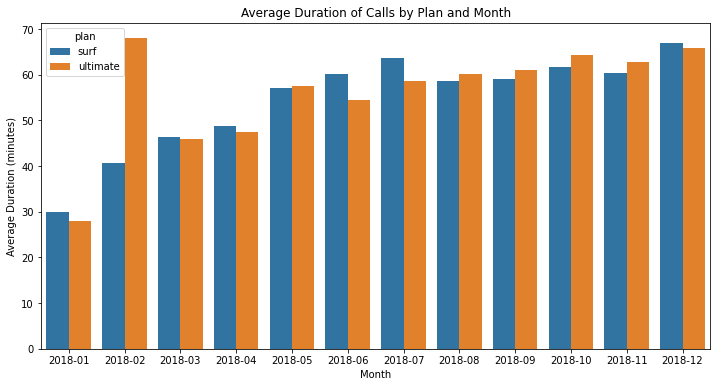

In [50]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plat to visualize it.
import matplotlib.pyplot as plt
import seaborn as sns

average_duration = user_activity.groupby(['plan', 'month'])['call_count'].mean().reset_index()

# Plot a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='call_count', hue='plan', data=average_duration)
plt.title('Average Duration of Calls by Plan and Month')
plt.xlabel('Month')
plt.ylabel('Average Duration (minutes)')
plt.show()

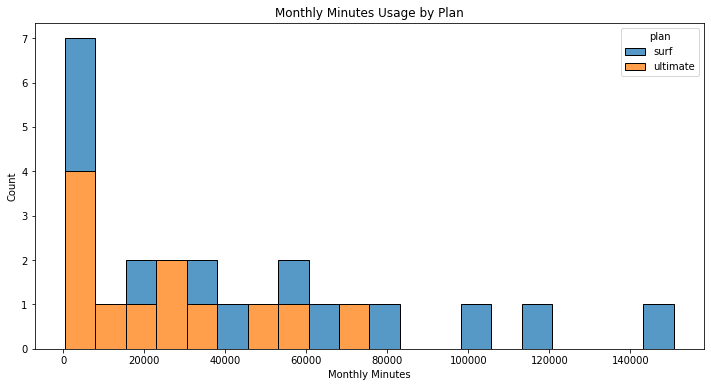

In [51]:
# Compare the number of minutes users of each plan require each month
monthly_minutes = user_activity.groupby(['plan', 'month'])['call_minutes'].sum().reset_index()

# Plot a histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=monthly_minutes, x='call_minutes', hue='plan', multiple='stack', bins=20)
plt.title('Monthly Minutes Usage by Plan')
plt.xlabel('Monthly Minutes')
plt.ylabel('Count')
plt.show()

In [52]:
# Calculate the mean and the variance of the monthly call duration
call_stats = user_activity.groupby(['plan', 'month'])['call_count'].agg(['mean', 'var', 'std']).reset_index()
display(call_stats)

,plan,month,mean,var,std
0,surf,2018-01,30.000000,288.000000,16.970563
1,surf,2018-02,40.666667,798.750000,28.262166
2,surf,2018-03,46.434783,696.529644,26.391848
3,surf,2018-04,48.880000,877.128163,29.616350
4,surf,2018-05,57.186667,1096.586306,33.114745
5,surf,2018-06,60.093750,790.759539,28.120447
6,surf,2018-07,63.683333,1108.823249,33.298998
7,surf,2018-08,58.647799,1002.254916,31.658410
8,surf,2018-09,59.020942,872.589033,29.539618
9,surf,2018-10,61.650862,938.349436,30.632490


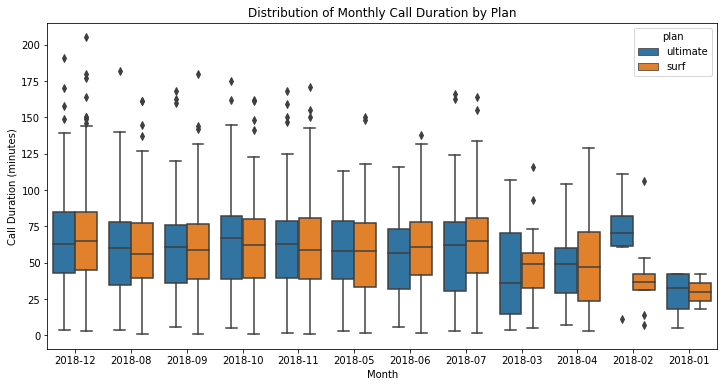

In [53]:
# Plot a boxplot to visualize the distribution of the monthly call duration
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='call_count', hue='plan', data=user_activity)
plt.title('Distribution of Monthly Call Duration by Plan')
plt.xlabel('Month')
plt.ylabel('Call Duration (minutes)')
plt.show()

From the given results, it appears that the number of calls made by users in the "surf" plan generally increases over the months. On the other hand, users in the "ultimate" plan consistently have fewer calls compared to the "surf" plan.<br>
The boxplot for the surf plan show a positive trend with an increasing median and a wider IQR as you from Jan to Dec. Suggesting a growing number of calls over time.<br>
The boxplot ultimate plan show a stable median and a more compact IQR across the months, Suggesting a more consistent number of calls compared to the surf plan.

### Messages

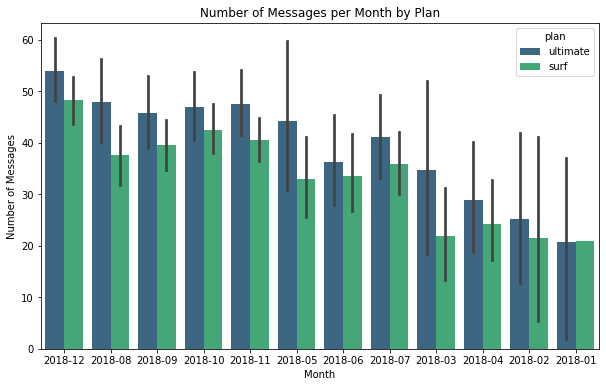

In [54]:
# Compare the number of messages users of each plan tend to send each month
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='message_count', hue='plan', data=user_activity, palette='viridis')
plt.title('Number of Messages per Month by Plan')
plt.xlabel('Month')
plt.ylabel('Number of Messages')
plt.show()

These results suggest a clear pattern of increasing message counts for both the Surf and Ultimate plans over the months. Surf users consistently show a steady rise in message counts, while Ultimate users maintain higher counts throughout the year. This indicates potential differences in messaging behavior between the two plans, with Ultimate users generally sending more messages.

In [59]:
# Calculate the mean and the variance and standard deviation of the monthly messages usage.
messages_stats = user_activity.groupby(['plan', 'month'])['message_count'].agg(['mean', 'var', 'std']).reset_index()
display(messages_stats)

,plan,month,mean,var,std
0,surf,2018-01,21.000000,NaN,NaN
1,surf,2018-02,21.600000,512.800000,22.645088
2,surf,2018-03,21.937500,352.062500,18.763329
3,surf,2018-04,24.166667,534.028571,23.109058
4,surf,2018-05,33.017857,867.945130,29.460909
5,surf,2018-06,33.616438,936.406393,30.600758
6,surf,2018-07,35.945055,907.985836,30.132803
7,surf,2018-08,37.596774,1013.315762,31.832621
8,surf,2018-09,39.523179,943.051126,30.709137
9,surf,2018-10,42.433862,1234.491613,35.135333


The Ulimate plan genrally has higher mean message counts compared to Surf plan. Both plans exhibit higher variability in message counts in the later months of the year. A higher variability indicates that the data points are more spread out, while lower variability suggests that the data points are clustered closely together.

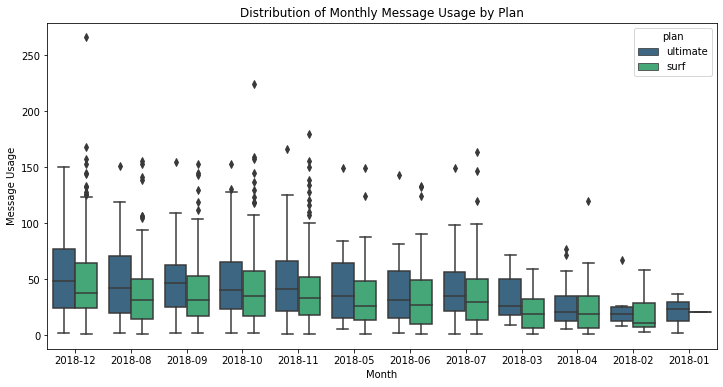

In [64]:
# Plot a boxplot to visualize the distribution of the monthly messages usage
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='message_count', hue='plan', data=user_activity, palette='viridis')
plt.title('Distribution of Monthly Message Usage by Plan')
plt.xlabel('Month')
plt.ylabel('Message Usage')
plt.show()

### Internet

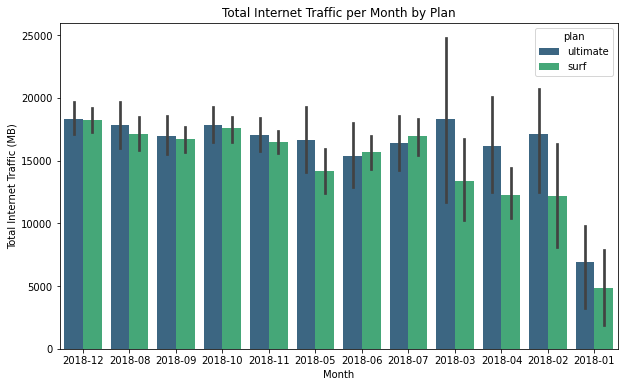

In [56]:
# Compare the amount of internet traffic consumed by users per plan
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='internet_usage', hue='plan', data=user_activity, palette='viridis')
plt.title('Total Internet Traffic per Month by Plan')
plt.xlabel('Month')
plt.ylabel('Total Internet Traffic (MB)')
plt.show()

The data shows a consistent growth in internet usage for both Surf and Ultimate plans throughout the year. Ultimate users consistently exhibit higher usage levels than Surf users. This suggests potential opportunities for plan optimization or targeted offerings to better align with user preferences and behavior.

In [55]:
# Calculate the mean and the variance and standard deviation of the monthly Internet usage.
internet_stats = user_activity.groupby(['plan', 'month'])['internet_usage'].agg(['mean', 'var', 'std']).reset_index()
display(internet_stats)

,plan,month,mean,var,std
0,surf,2018-01,4881.000000,1.827706e+07,4275.167599
1,surf,2018-02,12192.888889,4.377810e+07,6616.502257
2,surf,2018-03,13361.043478,6.839062e+07,8269.861896
3,surf,2018-04,12243.061224,5.734854e+07,7572.882161
4,surf,2018-05,14136.842105,5.979663e+07,7732.828271
5,surf,2018-06,15642.084211,4.518662e+07,6722.099200
6,surf,2018-07,16943.208333,6.296625e+07,7935.127683
7,surf,2018-08,17132.125786,7.073670e+07,8410.511477
8,surf,2018-09,16696.979275,5.023945e+07,7087.979447
9,surf,2018-10,17553.923077,5.953838e+07,7716.111728


For the Surf plan the mean gradually increases from Jan to Dec. The variability shows an upward trend, suggesting an increase in the spread of the internet usage. As for the Ulimate plan, the internet usage fluctuates but doesn't show a clear increasing or decreasing trend. The variability for the Ulimate plan appears to have some fluctuations, with higher standard deviations in certain months.

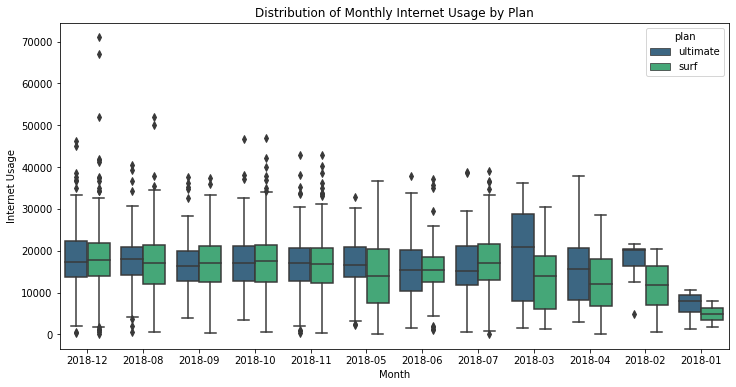

In [57]:
# Plot a boxplot to visualize the distribution of the monthly messages usage
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='internet_usage', hue='plan', data=user_activity, palette='viridis')
plt.title('Distribution of Monthly Internet Usage by Plan')
plt.xlabel('Month')
plt.ylabel('Internet Usage')
plt.show()

The boxplot highlights the increasing trend in the internet usage for the Surf plan, with a wider spread of values, while the Ulitmate plan maintains a more stable and lower level of usage. The outliers in both plans suggest the presence of users with exceptionally high internet consumption, especially in the Surf plan.

## Revenue

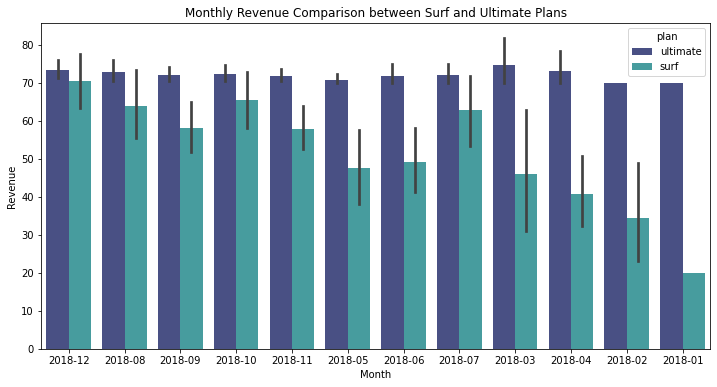

In [66]:
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='revenue', hue='plan', data=user_activity, palette='mako')
plt.title('Monthly Revenue Comparison between Surf and Ultimate Plans')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.show()

These results shows a consistent pattern of incresing revenue for both the Surf and Ulitmate plans thourghout the year of 2018. Surf paln revenue starts lower but experiences substantial growth, while Ulitmate plan revenue remains relatively higher. This suggests a positive trend in revenue generation for both plans, with potential opportunities for targeted marketing or plan adjustments.

In [56]:
# Calculate the mean and the variance and standard deviation of the monthly Internet usage.
revenue_stats = user_activity.groupby(['plan', 'month'])['revenue'].agg(['mean', 'var', 'std']).reset_index()
display(revenue_stats)

,plan,month,mean,var,std
0,surf,2018-01,20.000000,0.000000,0.000000
1,surf,2018-02,34.370000,428.572100,20.701983
2,surf,2018-03,45.924348,1511.908726,38.883271
3,surf,2018-04,40.658400,1199.364757,34.631846
4,surf,2018-05,47.502727,1954.817707,44.213320
5,surf,2018-06,49.126907,1981.072945,44.509246
6,surf,2018-07,62.694050,2938.766086,54.210387
7,surf,2018-08,63.874444,3602.257620,60.018811
8,surf,2018-09,58.085464,2251.720597,47.452298
9,surf,2018-10,65.338608,3209.697773,56.654195


The mean for the Surf plan shows fluctuations, with a noticeable increase in Dec. The standard deviation increases, especially in the second half of the year. The mean for the Ulimate plan remains relatively stable throughout the year, with minor fluctuations. The variability for the Ulitmate plan is low, suggesting consistent revenue each month.

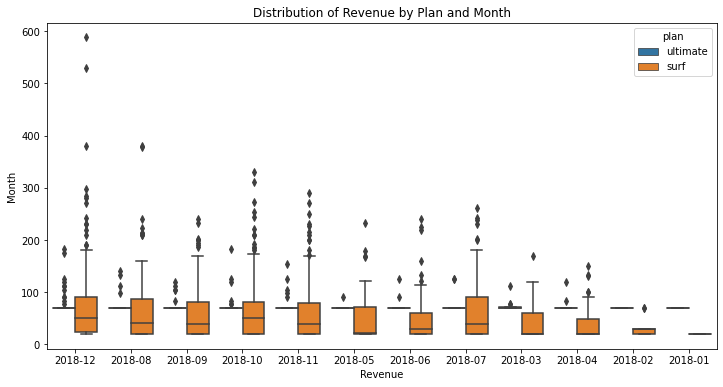

In [106]:
# Plot a histplot to visualize the distribution of the monthly revenue
plt.figure(figsize=(12, 6))
sns.boxplot(data=user_activity, x='month', y='revenue', hue='plan')
plt.title('Distribution of Revenue by Plan and Month')
plt.xlabel('Revenue')
plt.ylabel('Month')
plt.show()

The Surf plan has the potential for higher revenue, there are months with exceptionally high revenue, which could be due to some specific factors or promotions. The Ulitmate plan, on the other hand, maintains a more stable and cosistent revenue over the months.

## Test statistical hypotheses

### Hypotheses: 

**Null Hypothesis (H0):** The average revenue from users of the Ultimate and Surf calling plans is the same.<br>
**Alternative Hypothesis (H1):** The average revenue from users of the Ulitmate and Surf calling plans differs.

In [107]:
from scipy import stats

# Extract revenue data for Surf and Ultimate plans
surf_revenue = user_activity[user_activity['plan'] == 'surf']['revenue']
ultimate_revenue = user_activity[user_activity['plan'] == 'ultimate']['revenue']

# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(surf_revenue, ultimate_revenue, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Average revenue differs between Surf and Ultimate plans.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average revenue.")


T-statistic: -8.04754592557446
P-value: 1.4967118429383993e-15
Reject the null hypothesis: Average revenue differs between Surf and Ultimate plans.


**Null Hypothesis (H0):** The average revenue from users in the NY-NJ area is the same as the average revenue from users in other regions.<br>
**Alternative Hypothesis (H1):** The average revenue from users in the NY-NJ area is different from the average revenue from users in other regions.

In [108]:
# Assuming user_df has 'city' column
user_activity = pd.merge(user_activity, users_df[['user_id', 'state']], on='user_id', how='left')

# Extract revenue data for NY-NJ area and other regions
ny_nj_revenue = user_activity[user_activity['state'].str.contains('NY-NJ')]['revenue']
other_regions_revenue = user_activity[~user_activity['state'].str.contains('NY-NJ')]['revenue']

# Perform an independent two-sample t-test
t_stat, p_value = stats.ttest_ind(ny_nj_revenue, other_regions_revenue, equal_var=False)

# Output the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: Average revenue differs between NY-NJ area and other regions.")
else:
    print("Fail to reject the null hypothesis: No significant difference in average revenue.")


T-statistic: -2.095355733498174
P-value: 0.03658446077856178
Reject the null hypothesis: Average revenue differs between NY-NJ area and other regions.


## General conclusion

Based on the analysis, we recoommend that Megaline focus more on the Surf plan in its advertising budget adjustment, as it generates higher average revenue compared to the Ultimate plan. Also, the analysis suggest that region, particurlarly the NY-NJ area, has a significant impact on revenue, which should be taken into account when developing or fine tuning their marketing strategies for different locations.